#1. Librerías y cargue de archivo

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-02-ESTADISTICA/master/init.py
import init; init.init(force_download=False); 
from IPython.display import Image

replicating local resources


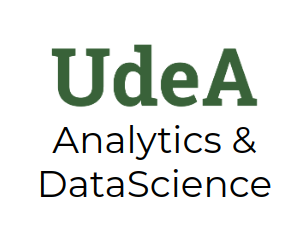

In [ ]:
Image("local/imgs/udea-datascience.png")

In [ ]:



from scipy.stats import pearsonr
from sklearn.preprocessing import OrdinalEncoder


# Tratamiento de datos
# ===========================================================================
import numpy as np
import pandas as pd
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min


# Librerias adicionales
# ==============================================================================
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA, IncrementalPCA
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# Configuración matplotlib
# ============================
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')




# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_excel("ICBFCUEGeneralPorToma.xlsx", na_values=0) # Read data


FileNotFoundError: ignored

#2. Exploración inicial y limpieza de datos

## Exploración inicial

In [ ]:
data.info()

## Filtración de Columnas sin valor agregado

In [ ]:
dataf = data.drop(data.columns[[0,1,2,3,4,5,6,8,10,11,12,13,14,17,18,19,20,23,27,28,29,30,31,32,33,34,35,36,37,38,39,40,43,44,45,46,47,48,49,50,51,56,59,63,65]], axis='columns')
dataf.info()

In [ ]:
dobject = dataf.select_dtypes('object')
dobject.head()
dobject.info()

In [ ]:
dint64 = dataf.select_dtypes('int64')
dint64.head()
dint64.info()

In [ ]:
dfloat64 = dataf.select_dtypes('float64')
dfloat64.head()
dfloat64.info()

CODIFICANDO DATOS CATEGORICOS DE SISBEN


In [ ]:
dobject.Sisben.value_counts()

In [ ]:
dobject['Sisben'].count()

In [ ]:
# asignando valor 0 a las variables que tengan NaN
df = pd.DataFrame(dataf["Sisben"])
df = df.fillna(0)
print(df)

In [ ]:
df.count()

## Codificación de Categoría Sisben

In [ ]:
# Creamos el codificador indicandole el orden de la variables, incluimos el cero para dar inicializacion desde 1
encoder = OrdinalEncoder(categories=[[0,"NO TIENE","A1", "A2", "A3","A4","A5", 
                                      "B1", "B2", "B3", "B4", "B5", "B6", "B7", 
                                      "C1","C2","C3","C4","C5","C6","C7","C8","C9","C10","C11","C12","C13","C14","C15","C16","C17","C18",
                                      "D1","D2","D3","D4","D5","D6","D7","D8","D9","D10","D11","D12","D13","D14","D15","D16","D17","D18","D19","D20","D21",
                                      "A"]])
# desde la pagina del gobierno se bajaron las diferentes clasificaciones que tiene la categorizacion del sisben, en donde:
#A= pobreza extrema (comprende a hogares en situación de pobreza  extrema. En este grupo los hogares estarán clasificados en 5 subgrupos, desde A1 hasta A5.)
#B= pobreza moderada (corresponde a hogares en condición de pobreza moderada. Este grupo tendrá 7 subgrupos desde el B1 hasta el B7.)
#C= Vulnerabilidad (corresponde a hogares en condición de vulnerabilidad. Este grupo tendrá 18 subgrupos desde el C1 hasta el C18. )
#D= Ni ´pobre ni vulnerable (comprende hogares que no están en situación de pobreza. Este grupo tendrá 21 subgrupos desde el D1 hasta el D21. )

# Ajustamos el codificador con la variable sisben y la transformamos
encoder.fit(df[["Sisben"]])
df["Sisben-encoded"] = encoder.transform(df[["Sisben"]])
dataf["Sisben"]=df["Sisben-encoded"]   # cambiamos en el dataf la columna sisben de datos categoricos por los codificados

In [ ]:
df[["Sisben", "Sisben-encoded"]].head(1000)

In [ ]:
graf_sisben=df.Sisben.value_counts()
graf_sisben

In [ ]:
# Creaemos una gráfica de barras para observa la densidad poblacional
graf_sisben.plot(kind="bar")

In [ ]:
df["Sisben-encoded"].describe()

3. #Inicio Analisis Clustering

##Obtención de variables Dummies

In [ ]:
dDum= dataf.copy()
dDum =pd.get_dummies(dDum, drop_first=1)

In [ ]:
dDum.info()


## Escalamiento de variables

In [ ]:
X_scaled = preprocessing.Normalizer().fit_transform(dDum)
X_scaled

#3. Selección del *K* para método K-Means

## Método del codo

In [ ]:
inertias = []

range_n_clusters=range(2,15)
for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        #n_init       = 20, 
                        random_state = 10
                    )
    modelo_kmeans.fit(X_scaled)
    inertias.append(modelo_kmeans.inertia_)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

## Método Silhouette

In [ ]:
def silhouette_analysis(X, range_n_clusters):
    #range_n_clusters = [10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21]

    
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1) = plt.subplots(1, 1)
        fig.set_size_inches(19, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for %s clustering on sample data "
                      "with n_clusters = %d, score = %.3f" % (clusterer.__class__.__name__, n_clusters,silhouette_avg)),
                     fontsize=14, fontweight='bold')

In [ ]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        #n_init       = 20, 
                        random_state = 10
                    )
    cluster_labels = modelo_kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(15, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

In [ ]:
silhouette_analysis(X_scaled, range_n_clusters)

# 4. Creación del modelo con K-Means

In [ ]:
#Se define el algoritmo junto con el valor de K
k=2
algoritmo = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, n_init = 10)

#Se entrena el algoritmo
algoritmo.fit(X_scaled)

## Resumen de métricas con K-Means

In [ ]:
nro=[]
silueta=[]
calinski=[]
davies=[]
j=2
for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        #n_init       = 20, 
                        random_state = 10
                    )
    cluster_labels = modelo_kmeans.fit_predict(X_scaled)
    nro.append(j)
    silueta.append(silhouette_score(X_scaled, cluster_labels))
    calinski.append(calinski_harabasz_score(X_scaled, cluster_labels))
    davies.append(davies_bouldin_score(X_scaled, cluster_labels))
    j=j+1

In [ ]:

data = {'# de Clusters': nro, 'Score Silhouette': silueta, 'Score Calinski-Harabasz':calinski, 'Score Davies-Bouldin':davies}
metricas_kmeans = pd.DataFrame(data=data)


In [ ]:
metricas_kmeans

#5. Visualización de clusters

In [ ]:
#Se obtiene los datos de los centroides y las etiquetas
centroides, cluster = algoritmo.cluster_centers_, algoritmo.labels_

In [ ]:
# Obtenemos las etiquetas de cada punto de nuestros datos
dClus = dDum.copy()
dClus['cluster'] = algoritmo.labels_

# Obtenemos los centroids
C = algoritmo.cluster_centers_

In [ ]:
dClus.head(10)

In [ ]:
dClus.groupby("cluster").count().head()

In [ ]:
dClus.describe()

In [ ]:
centroides = pd.DataFrame(data=algoritmo.cluster_centers_, columns =dDum.columns)
centroides.head()

In [ ]:
dClus.groupby('cluster').size()

In [ ]:
dClus[dClus['cluster']==1][:10].sort_values('cluster',ascending=False)

##Gráficos

In [ ]:
bar = centroides.T.copy()

fig, axes = plt.subplots(nrows=15, ncols=3)
axe = axes.flatten()

for i,b in enumerate(bar.index):
  bar.loc[[b]].plot(kind='bar',figsize=(25,40),sort_columns=True,ax=axe[i],xticks=(()),yticks=(()),title=b)

In [ ]:
centroides = algoritmo.cluster_centers_
etiquetas = algoritmo.labels_

In [ ]:
plt.plot(X_scaled[etiquetas==0,0],X_scaled[etiquetas==0,1],'r.', label='Cluster 1')
plt.plot(X_scaled[etiquetas==1,0],X_scaled[etiquetas==1,1],'g.', label='Cluster 2')
plt.plot(X_scaled[etiquetas==2,0],X_scaled[etiquetas==2,1],'b.', label='Cluster 3')



plt.plot(centroides[:,0],centroides[:,1],'mo',markersize=8, label='centroides')

plt.legend(loc='best')
plt.show()

#6. Creación de modelo con Clustering Jerárquico

In [ ]:
modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            distance_threshold = 0,
                            n_clusters         = None
                     )
modelo_hclust_ward.fit(X=X_scaled)

In [ ]:
def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

Dendograma

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
altura_corte = 5.3
#altura_corte = 6

plot_dendrogram(modelo_hclust_ward, color_threshold=altura_corte, ax=ax)
ax.set_title("Distancia euclídea, Linkage ward")
ax.axhline(y=altura_corte, c = 'black', linestyle='--', label='altura corte')
ax.legend();

Método de Silueta

In [ ]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
                    affinity   = 'euclidean',
                    linkage    = 'ward',
                    n_clusters = n_clusters
             )

    cluster_labels = modelo.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

Creación del modelo

In [ ]:
# Modelo
# ==============================================================================
modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            n_clusters = 3
                     )
modelo_hclust_ward.fit(X=X_scaled)

## Métricas de Clustering Jerárquico

In [ ]:
nro=[]
silueta=[]
calinski=[]
davies=[]
j=2
for n_clusters in range_n_clusters:
    modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            n_clusters = n_clusters
                     )
    cluster_labels = modelo_hclust_ward.fit_predict(X_scaled)
    nro.append(j)
    silueta.append(silhouette_score(X_scaled, cluster_labels))
    calinski.append(calinski_harabasz_score(X_scaled, cluster_labels))
    davies.append(davies_bouldin_score(X_scaled, cluster_labels))
    j=j+1

In [ ]:
data = {'# de Clusters': nro, 'Score Silhouette': silueta, 'Score Calinski-Harabasz':calinski, 'Score Davies-Bouldin':davies}
metricas_hclust = pd.DataFrame(data=data)


In [ ]:
metricas_hclust

#7. Reducción de dimensionalidad

## PCA

In [ ]:
modelo_pca = PCA(n_components = 2)
pca = modelo_pca.fit_transform(X_scaled)


#Se aplicar la reducción de dimsensionalidad a los centroides
centroides_pca = modelo_pca.transform(centroides)

In [ ]:
#Se asignan los colores a cada clústeres

colores = ['blue', 'red', 'green', 'orange', 'gray', 'brown', 'slateblue', 'sprintgreen', 'magenta']


colores_cluster = [colores[cluster[i]] for i in range(0,len(pca))]

In [ ]:
cluster

In [ ]:
pca_data=np.vstack((pca.T, cluster, colores_cluster))
pca_df=pd.DataFrame(pca_data.T, columns=['P1', 'P2', 'cluster', 'color'])
pca_df.head(20)

In [ ]:
pca

In [ ]:
### GRAFICAR LOS DATOS JUNTO A LOS RESULTADOS ###
# Se aplica la reducción de dimensionalidad a los datos
plt.rcParams['figure.figsize'] = (16,6)
j=k-1
#Se grafica los componentes PCA
plt.scatter(pca[:, 0], pca[:, 1], c = colores_cluster, marker = 'o',alpha = 0.4)

#Se grafican los centroides
plt.scatter(centroides_pca[:, 0], centroides_pca[:, 1], marker = 'x', s = 100, linewidths = 3, c = colores[0:k])
plt.show()

## Métricas de PCA

In [ ]:
pca

In [ ]:
nro=[]
silueta=[]
calinski=[]
davies=[]
j=2
for n_clusters in range_n_clusters:
    modelo_pca = KMeans(
                        n_clusters   = n_clusters, 
                        #n_init       = 20, 
                        random_state = 10
                    )
    cluster_labels = modelo_pca.fit_predict(pca_data.T[:,0:2])
    nro.append(j)
    silueta.append(silhouette_score(pca_data.T[:,0:2], cluster_labels))
    calinski.append(calinski_harabasz_score(pca_data.T[:,0:2], cluster_labels))
    davies.append(davies_bouldin_score(pca_data.T[:,0:2], cluster_labels))
    j=j+1

In [ ]:

data = {'# de Clusters': nro, 'Score Silhouette': silueta, 'Score Calinski-Harabasz':calinski, 'Score Davies-Bouldin':davies}
metricas_pca = pd.DataFrame(data=data)


In [ ]:
metricas_pca

## PCA Incremental

In [ ]:
modelo_ipca = IncrementalPCA(n_components=2, batch_size=32)
ipca = modelo_ipca.fit_transform(X_scaled)

In [ ]:
#Se asignan los colores a cada clústeres

colores = ['blue', 'red', 'green', 'orange', 'gray', 'brown', 'slateblue', 'sprintgreen', 'magenta']


colores_cluster = [colores[cluster[i]] for i in range(0,len(pca))]

In [ ]:
ipca_data=np.vstack((ipca.T, cluster, colores_cluster))
ipca_df=pd.DataFrame(ipca_data.T, columns=['P1', 'P2', 'cluster', 'color'])
ipca_df.head(20)

In [ ]:
### GRAFICAR LOS DATOS JUNTO A LOS RESULTADOS ###
# Se aplica la reducción de dimensionalidad a los datos
plt.rcParams['figure.figsize'] = (16,6)
j=k-1
#Se grafica los componentes IPCA
plt.scatter(ipca[:, 0], ipca[:, 1], c = colores_cluster, marker = 'o',alpha = 0.4)



## Métricas de IPCA

In [ ]:
nro=[]
silueta=[]
calinski=[]
davies=[]
clases_ipca=[]
j=2
for n_clusters in range_n_clusters:
    modelo_ipca = KMeans(
                        n_clusters   = n_clusters, 
                        #n_init       = 20, 
                        random_state = 10
                    )
    cluster_labels = modelo_ipca.fit_predict(ipca_data.T[:,0:2])
    clases_ipca.append(cluster_labels)
    nro.append(j)
    silueta.append(silhouette_score(ipca_data.T[:,0:2], cluster_labels))
    calinski.append(calinski_harabasz_score(ipca_data.T[:,0:2], cluster_labels))
    davies.append(davies_bouldin_score(ipca_data.T[:,0:2], cluster_labels))
    j=j+1

In [ ]:
data = {'# de Clusters': nro, 'Score Silhouette': silueta, 'Score Calinski-Harabasz':calinski, 'Score Davies-Bouldin':davies}
metricas_ipca = pd.DataFrame(data=data)


In [ ]:
metricas_ipca

##t-SNE

In [ ]:
modelo_tsne = TSNE(n_components = 2, perplexity=30, method='exact', random_state=1234)
tsne = modelo_tsne.fit_transform(X_scaled)
#centroides_tsne = modelo_tsne.transform(centroides)

In [ ]:
#Se asignan los colores a cada clúster

colores = ['blue', 'red', 'green', 'orange', 'gray', 'brown', 'slateblue', 'sprintgreen', 'magenta',  'skyblue']

colores_cluster = [colores[cluster[i]] for i in range(0,len(tsne))]

In [ ]:
tsne_data=np.vstack((tsne.T, cluster, colores_cluster))
tsne_df=pd.DataFrame(tsne_data.T, columns=['P1', 'P2', 'cluster', 'color'])
tsne_df.head(8)

In [ ]:
### GRAFICAR LOS DATOS JUNTO A LOS RESULTADOS ###
# Se aplica la reducción de dimensionalidad a los datos
plt.rcParams['figure.figsize'] = (16,6)

#Se grafica los componentes tSNE
plt.scatter(tsne[:, 0], tsne[:, 1], c = colores_cluster, 
            marker = 'o',alpha = 0.4)

##Metricas de t-SNE

In [ ]:
nro=[]
silueta=[]
calinski=[]
davies=[]
clases_tsne=[]
j=2
for n_clusters in range_n_clusters:
    modelo_tsne = KMeans(
                        n_clusters   = n_clusters, 
                        #n_init       = 20, 
                        random_state = 10
                    )
    cluster_labels = modelo_tsne.fit_predict(tsne_data.T[:,0:2])
    clases_tsne.append(cluster_labels)
    nro.append(j)
    silueta.append(silhouette_score(tsne_data.T[:,0:2], cluster_labels))
    calinski.append(calinski_harabasz_score(tsne_data.T[:,0:2], cluster_labels))
    davies.append(davies_bouldin_score(tsne_data.T[:,0:2], cluster_labels))
    j=j+1

In [ ]:

data = {'# de Clusters': nro, 'Score Silhouette': silueta, 'Score Calinski-Harabasz':calinski, 'Score Davies-Bouldin':davies}
metricas_tsne = pd.DataFrame(data=data)


In [ ]:
metricas_tsne

,# de Clusters,Score Silhouette,Score Calinski-Harabasz,Score Davies-Bouldin
0,2,0.427076,3240.109402,0.957164
1,3,0.438608,3891.473542,0.804450
2,4,0.445198,4136.327121,0.751894
3,5,0.457785,4926.404576,0.724363
4,6,0.463517,4814.685796,0.752439
5,7,0.458161,4835.658818,0.719331
6,8,0.432235,5068.054530,0.762736
7,9,0.445333,5283.283916,0.706295
8,10,0.435837,5465.492730,0.742554
9,11,0.437748,5615.190176,0.744589


#8. Selección de método y número de Clusters

##Resumen de métricas

In [ ]:
metricas_kmeans.head(14)

,# de Clusters,Score Silhouette,Score Calinski-Harabasz,Score Davies-Bouldin
0,2,0.491766,5042.164551,0.768223
1,3,0.402277,4706.577695,0.863599
2,4,0.340266,4298.638174,0.986444
3,5,0.290371,3737.570210,1.140388
4,6,0.298675,3440.543181,1.073030
5,7,0.252655,3178.464687,1.165482
6,8,0.241174,2945.193641,1.213691
7,9,0.249084,2779.073055,1.199140
8,10,0.232733,2632.310780,1.250760
9,11,0.234336,2510.171009,1.228064


In [ ]:
metricas_hclust.head(14)

,# de Clusters,Score Silhouette,Score Calinski-Harabasz,Score Davies-Bouldin
0,2,0.451575,4473.200085,0.810871
1,3,0.369658,4214.697235,0.900257
2,4,0.257612,3469.163511,1.088304
3,5,0.233479,3132.512703,1.083242
4,6,0.248018,2867.689069,1.145911
5,7,0.206191,2675.038913,1.270841
6,8,0.227500,2562.970941,1.241746
7,9,0.194967,2407.926345,1.267669
8,10,0.200164,2288.471496,1.211840
9,11,0.184857,2208.984677,1.300593


In [ ]:
metricas_pca.head(14)

,# de Clusters,Score Silhouette,Score Calinski-Harabasz,Score Davies-Bouldin
0,2,0.556749,6877.108763,0.639972
1,3,0.492861,7771.621415,0.665589
2,4,0.451335,8277.932155,0.712327
3,5,0.415495,7983.233132,0.775425
4,6,0.375914,7658.463445,0.838733
5,7,0.366776,7393.979495,0.864497
6,8,0.376830,7262.931881,0.849109
7,9,0.370222,7216.453940,0.855393
8,10,0.367356,7127.091335,0.866030
9,11,0.360900,7015.680645,0.842306


In [ ]:
metricas_ipca.head(14)

,# de Clusters,Score Silhouette,Score Calinski-Harabasz,Score Davies-Bouldin
0,2,0.556930,6883.177403,0.640382
1,3,0.494300,7804.871258,0.663084
2,4,0.453048,8354.366797,0.710059
3,5,0.416097,8050.534269,0.775668
4,6,0.376949,7730.746845,0.844301
5,7,0.369911,7484.960676,0.862770
6,8,0.383190,7407.004439,0.838611
7,9,0.375350,7361.747425,0.846336
8,10,0.374500,7273.677424,0.855803
9,11,0.364826,7195.612094,0.833930


In [ ]:
metricas_tsne

,# de Clusters,Score Silhouette,Score Calinski-Harabasz,Score Davies-Bouldin
0,2,0.427076,3240.109402,0.957164
1,3,0.438608,3891.473542,0.804450
2,4,0.445198,4136.327121,0.751894
3,5,0.457785,4926.404576,0.724363
4,6,0.463517,4814.685796,0.752439
5,7,0.458161,4835.658818,0.719331
6,8,0.432235,5068.054530,0.762736
7,9,0.445333,5283.283916,0.706295
8,10,0.435837,5465.492730,0.742554
9,11,0.437748,5615.190176,0.744589


In [ ]:
nombre_metricas=['Silhouette','Calinski-Harabasz','Davies-Bouldin']
clusters_kmeans=[2,2,2]
clusters_hclust=[2,2,2]
clusters_pca=[2,4,2]
clusters_ipca=[2,4,2]
clusters_tsne=[6,9,9]

data = {'Métrica': nombre_metricas, 'K-Means': clusters_kmeans, 'Jerarquico':clusters_hclust, 'PCA':clusters_pca, 'PCA Incremental':clusters_ipca,'TSNE':clusters_tsne}
metricas_resumen = pd.DataFrame(data=data)

In [ ]:
nombre_metricas=['Silhouette','Calinski-Harabasz','Davies-Bouldin']
clusters_kmeans=[metricas_kmeans['Score Silhouette'].max(),metricas_kmeans['Score Calinski-Harabasz'].max(),metricas_kmeans['Score Davies-Bouldin'].min()]
clusters_hclust=[metricas_hclust['Score Silhouette'].max(),metricas_hclust['Score Calinski-Harabasz'].max(),metricas_hclust['Score Davies-Bouldin'].min()]
clusters_pca=[metricas_pca['Score Silhouette'].max(),metricas_pca['Score Calinski-Harabasz'].max(),metricas_pca['Score Davies-Bouldin'].min()]
clusters_ipca=[metricas_ipca['Score Silhouette'].max(),metricas_ipca['Score Calinski-Harabasz'].max(),metricas_ipca['Score Davies-Bouldin'].min()]
clusters_tsne=[metricas_tsne['Score Silhouette'].max(),metricas_tsne['Score Calinski-Harabasz'].max(),metricas_tsne['Score Davies-Bouldin'].min()]

data = {'Métrica': nombre_metricas, 'K-Means': clusters_kmeans, 'Jerarquico':clusters_hclust, 'PCA':clusters_pca, 'PCA Incremental':clusters_ipca, 'TSNE':clusters_tsne}
metricas_score = pd.DataFrame(data=data)

In [ ]:
metricas_score

,Métrica,K-Means,Jerarquico,PCA,PCA Incremental,TSNE
0,Silhouette,0.491766,0.451575,0.556749,0.556930,0.463517
1,Calinski-Harabasz,5042.164551,4473.200085,8277.932155,8354.366797,5619.360754
2,Davies-Bouldin,0.768223,0.810871,0.639972,0.640382,0.706295


In [ ]:
metricas_resumen

,Métrica,K-Means,Jerarquico,PCA,PCA Incremental,TSNE
0,Silhouette,2,2,2,2,6
1,Calinski-Harabasz,2,2,4,4,9
2,Davies-Bouldin,2,2,2,2,9


##Justificación del método y número de clusters Escogido

 

1.   Se escogió una combinación de métodos, aplicando primero reducción de dimensionalidad con PCA Incremental y luego el método K-Means
2.   El número de clusters seleccionados es de 2



##Generación de vector de clases y dataset final para exportar





In [ ]:
clases=clases_ipca[0]
clases

array([1, 1, 0, ..., 1, 0, 0], dtype=int32)

In [ ]:
dDum['Clases']=clases

In [ ]:
display(dDum)

,Edad en Meses,Meses Lactancia Materna Exclusiva,Meses Lactancia Materna Total,Peso,Talla,Sisben,Nombre del Servicio_DESARROLLO INFANTIL EN MEDIO FAMILIAR SIN ARRIENDO - FAMILIAR,Nombre del Servicio_HOGARES INFANTILES - INSTITUCIONAL,Tipo Documento Beneficiario_SIN DOCUMENTO,Sexo_Mujer,...,Estado IMC_sobrepeso,¿En el sistema general de seguridad social en salud usted es?_AFILIADO REGIMEN ESPECIAL,¿En el sistema general de seguridad social en salud usted es?_AFILIADO REGIMEN SUBSIDIADO,¿En el sistema general de seguridad social en salud usted es?_NO AFILIADO(A),¿El beneficiario cuenta con el carnet de vacunación?_S,¿El carnet de vacunación se encuentra al día en las vacunas y dosis que corresponden a la edad del niño o niña?_SI,El beneficiario cuenta con Carnet de Crecimiento y Desarrollo_SI,Estado_VINCULADO,Talla inferior última toma_SI,Clases
0,12,7,7,10.0,73.0,4.0,1,0,0,1,...,0,0,1,0,1,1,1,1,0,1
1,1,1,1,6.2,58.0,1.0,1,0,1,0,...,0,0,0,1,1,0,0,1,0,1
2,58,6,18,14.3,99.6,1.0,0,0,1,0,...,0,0,0,1,1,1,1,1,0,0
3,61,6,18,15.5,102.1,1.0,0,0,1,0,...,0,0,0,1,1,1,1,1,0,0
4,0,0,0,3.8,50.0,1.0,1,0,1,1,...,0,0,0,1,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556,52,6,18,13.6,100.8,1.0,0,0,1,0,...,0,0,0,1,1,1,1,1,0,0
3557,56,6,18,14.6,102.5,1.0,0,0,1,0,...,0,0,0,1,1,1,1,1,0,0
3558,13,8,8,10.0,72.0,1.0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3559,53,6,14,15.0,101.0,1.0,0,1,1,1,...,0,0,0,1,1,1,1,1,0,0


##Exportando el dataset con clases

In [ ]:
dDum.to_csv("Dataset_With_Classes.csv", sep=';')

SyntaxError: ignored